## Basic Steps

1. Run a baseline training script to build a speech commands model.
2. Add in your custom word to the training and test/validation sets.
   - Modify labels, shape of your output tensor in the model.
   - Make sure that feature extractor for the model aligns with the feature extractor 
     used in the arduino code.
3. Re-train model. => TF Model using floating-point numbers, that recognizes Google word and custom word.
4. Quantize the model and convert to TFlite. => keyword_model.tflite file
5. Convert tflite to .c file, using xxd => model_data.cc
6. Replace contents of existing micro_features_model.cpp with output of xxd.

All of the above steps are done in this notebook for the commands 'left', 'right'.

7. In micro_speech.ino, modify micro_op_resolver (around line 80) to add any necessary operations (DIFF_FROM_LECTURE)
8. In micro_features_model_settings.h, modify kSilenceIndex and kUnknownIndex, depending on 
where you have them in commands.  
  - Commands = ['left', 'right', '_silence', '_unknown'] => kSilenceIndex=2, kUnknownIndex=3
9. In micro_features_model_settings.cpp, modify kCategoryLabels to correspond to commands in this script.
10. In micro_features_micro_model_settings.h, set kFeatureSliceDurationMs, kFeatureSliceStrideMs to match what is passed to microfrontend as window_size, window_step, respectively.
11. Rebuild Arduino program, run it, recognize the two target words.
12. Experiment with model architecture, training parameters/methods, augmentation, more data-gathering, etc.

*Note*:  As of 5/3/21, this model uses 22% of flash and 49.5% of RAM, so there is substantial space to improve the model, but the latency is about 208ms, which is probably too slow.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
# from tqdm import tqdm # replace with this if moving out of notebook

import os
import pathlib

from datetime import datetime as dt

from IPython import display

2023-05-01 12:14:06.603446: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-01 12:14:06.605445: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-01 12:14:06.643263: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-01 12:14:06.643835: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 12:14:07.410829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

2.12.0


In [2]:
print("Is CUDA available? ", tf.test.is_built_with_cuda())
print("Number of available devices: ", len(tf.config.list_physical_devices('GPU')))

Is CUDA available?  True
Number of available devices:  0


2023-05-01 12:14:08.747946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 12:14:08.748436: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
i16min = -2**15
i16max = 2**15-1
fsamp = 16000
wave_length_ms = 1000
wave_length_samps = int(wave_length_ms*fsamp/1000)
window_size_ms= 30
window_step_ms= 20
num_filters = 40
use_microfrontend = True
dataset = 'full-speech-files'
# dataset = 'full-speech-ds' # use the full speech commands as a pre-built TF dataset 
#dataset = 'full-speech-files' # use the full speech commands stored as files 

silence_str = "_silence"  
unknown_str = "_unknown"

Apply the frontend to an example signal.

In [5]:
commands = ['computer', 'yes']
if dataset == 'mini-speech':
  data_dir = pathlib.Path('/home/david/Documents/GitHub/project-2-team-1/data/mini-speech/')
  if not data_dir.exists():
    tf.keras.utils.get_file('mini_speech_commands.zip',
          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
          extract=True, cache_dir='.', cache_subdir='data')
  # commands = np.array(tf.io.gfile.listdir(str(data_dir))) # if you want to use all the command words
  # commands = commands[commands != 'README.md']
elif dataset == 'full-speech-files':
  # data_dir = '/dfs/org/Holleman-Coursework/data/speech_dataset'
  data_dir = pathlib.Path('/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/')

elif dataset == 'full-speech-ds':
    raise RuntimeError("full-speech-ds is not really supported yet")

In [6]:
data_dir

PosixPath('/home/david/Documents/GitHub/project-2-team-1/data/custom-speech')

In [7]:
label_list = commands.copy()
label_list.insert(0, silence_str)
label_list.insert(1, unknown_str)
print('label_list:', label_list)

label_list: ['_silence', '_unknown', 'computer', 'yes']


In [8]:
!ls $data_dir/

computer  testing_list.txt   unknown		  yes
noise	  training_list.txt  validation_list.txt


In [9]:
if dataset == 'mini-speech' or dataset == 'full-speech-files':
    filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav') 
    # with the next commented-out line, you can choose only files for words in label_list
    # filenames = tf.concat([tf.io.gfile.glob(str(data_dir) + '/' + cmd + '/*') for cmd in label_list], 0)
    filenames = tf.random.shuffle(filenames)
    num_samples = len(filenames)
    print('Number of total examples:', num_samples)
    # print('Number of examples per label:',
    #       len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
    print('Example file tensor:', filenames[0])

Number of total examples: 2017
Example file tensor: tf.Tensor(b'/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/computer/computer_Sample33_RShift3_0.wav', shape=(), dtype=string)


In [10]:
filenames
# tf.strings.split(filenames[0], os.path.sep)[-2].numpy().decode('utf8')

<tf.Tensor: shape=(2017,), dtype=string, numpy=
array([b'/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/computer/computer_Sample33_RShift3_0.wav',
       b'/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/yes/28ed6bc9_nohash_2.wav',
       b'/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/yes/d3f22f0e_nohash_0.wav',
       ...,
       b'/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/computer/computer_Sample61_RShift1_0.wav',
       b'/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/yes/61a9f72a_nohash_0.wav',
       b'/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/yes/4a1e736b_nohash_1.wav'],
      dtype=object)>

In [11]:
# Not really necessary, but just look at a few of the files to make sure that 
# they're the correct files, shuffled, etc.
for i in range(10):
    print(filenames[i].numpy().decode('utf8'))

/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/computer/computer_Sample33_RShift3_0.wav
/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/yes/28ed6bc9_nohash_2.wav
/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/yes/d3f22f0e_nohash_0.wav
/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/yes/459345ea_nohash_0.wav
/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/yes/5c8af87a_nohash_1.wav
/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/yes/422d3197_nohash_0.wav
/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/yes/44dad20e_nohash_0.wav
/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/yes/20d3f11f_nohash_0.wav
/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/yes/28e47b1a_nohash_3.wav
/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/yes/3bfd30e6_nohash_2.wav


In [12]:
if dataset == 'mini-speech':
  print('Using mini-speech')
  num_train_files = int(0.8*num_samples) 
  num_val_files = int(0.1*num_samples) 
  num_test_files = num_samples - num_train_files - num_val_files
  train_files = filenames[:num_train_files]
  val_files = filenames[num_train_files: num_train_files + num_val_files]
  test_files = filenames[-num_test_files:]

elif dataset == 'full-speech-files':  
  # the full speech-commands set lists which files are to be used
  # as test and validation data; train with everything else
  fname_val_files = os.path.join(data_dir, 'validation_list.txt')    
  with open(fname_val_files) as fpi_val:
    val_files = fpi_val.read().splitlines()
  # validation_list.txt only lists partial paths
  val_files = [os.path.join(data_dir, fn) for fn in val_files]
  fname_test_files = os.path.join(data_dir, 'testing_list.txt')

  with open(fname_test_files) as fpi_tst:
    test_files = fpi_tst.read().splitlines()
  # testing_list.txt only lists partial paths
  test_files = [os.path.join(data_dir, fn).rstrip() for fn in test_files]    

  # convert the TF tensor filenames into an array of strings so we can use basic python constructs
  train_files = [f.decode('utf8') for f in filenames.numpy()]
  # don't train with the _background_noise_ files; exclude when directory name starts with '_'
  train_files = [f for f in train_files if f.split('/')[-2][0] != '_']
  # validation and test files are listed explicitly in *_list.txt; train with everything else
  train_files = list(set(train_files) - set(test_files) - set(val_files))
  # now convert back into a TF tensor so we can use the tf.dataset pipeline
  train_files = tf.constant(train_files)    
  print("full-speech-files is in progress.  Good luck!")

# if dataset == 'full-speech-files':
#   train_files = []
#   val_files = []
#   test_files = []

#   with open('/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/training_list.txt') as train_f:
#     train_files = train_f.read().splitlines()

#   with open('/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/testing_list.txt') as test_f:
#     test_files = test_f.read().splitlines()

#   with open('/home/david/Documents/GitHub/project-2-team-1/data/custom-speech/validation_list.txt') as val_f:
#     val_files = val_f.read().splitlines()

# print('Training set size', len(train_files))
# print('Validation set size', len(val_files))
# print('Test set size', len(test_files))


full-speech-files is in progress.  Good luck!


In [13]:
print(f"Number of training files: {len(train_files)}")

Number of training files: 1412


In [14]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [15]:
# @tf.function
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  in_set = tf.reduce_any(parts[-2] == label_list)
  label = tf.cond(in_set, lambda: parts[-2], lambda: tf.constant(unknown_str))
  # print(f"parts[-2] = {parts[-2]}, in_set = {in_set}, label = {label}")
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return  label # parts[-2]

In [16]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [17]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 

  # same length (16000 samples)
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)

  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram


Function to convert each waveform in a set into a spectrogram, then convert those
back into a dataset using `from_tensor_slices`.  (We should be able to use 
`wav_ds.map(get_spectrogram_and_label_id)`, but there is a problem with that process).
   

In [18]:
def create_silence_dataset(num_waves, samples_per_wave, rms_noise_range=[0.01,0.2], silent_label=silence_str):
    # create num_waves waveforms of white gaussian noise, with rms level drawn from rms_noise_range
    # to act as the "silence" dataset
    rng = np.random.default_rng()
    rms_noise_levels = rng.uniform(low=rms_noise_range[0], high=rms_noise_range[1], size=num_waves)
    rand_waves = np.zeros((num_waves, samples_per_wave), dtype=np.float32) # pre-allocate memory
    for i in range(num_waves):
        rand_waves[i,:] = rms_noise_levels[i]*rng.standard_normal(samples_per_wave)
    labels = [silent_label]*num_waves
    return tf.data.Dataset.from_tensor_slices((rand_waves, labels))  

In [19]:
def wavds2specds(waveform_ds, verbose=True):
  wav, label = next(waveform_ds.as_numpy_iterator())
  one_spec = get_spectrogram(wav)
  one_spec = tf.expand_dims(one_spec, axis=0)  # add a 'batch' dimension at the front
  one_spec = tf.expand_dims(one_spec, axis=-1) # add a singleton 'channel' dimension at the back    

  num_waves = 0 # count the waveforms so we can allocate the memory
  for wav, label in waveform_ds:
    num_waves += 1
  print(f"About to create spectrograms from {num_waves} waves")
  spec_shape = (num_waves,) + one_spec.shape[1:] 
  spec_grams = np.nan * np.zeros(spec_shape)  # allocate memory
  labels = np.nan * np.zeros(num_waves)
  idx = 0
  for wav, label in waveform_ds:    
    if verbose and idx % 250 == 0:
      print(f"\r {idx} wavs processed", end='')
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams[idx, ...] = spectrogram
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == np.array(label_list))    
    labels[idx] = new_label_id # for numeric labels
    # labels.append(new_label) # for string labels
    idx += 1
  labels = np.array(labels, dtype=int)
  output_ds = tf.data.Dataset.from_tensor_slices((spec_grams, labels))  
  return output_ds

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_train_files = len(train_files)
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = wavds2specds(waveform_ds)

2023-05-01 12:14:09.463348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1412]
	 [[{{node Placeholder/_0}}]]


About to create spectrograms from 1412 waves
 1250 wavs processed

2023-05-01 12:14:11.089556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1412]
	 [[{{node Placeholder/_0}}]]


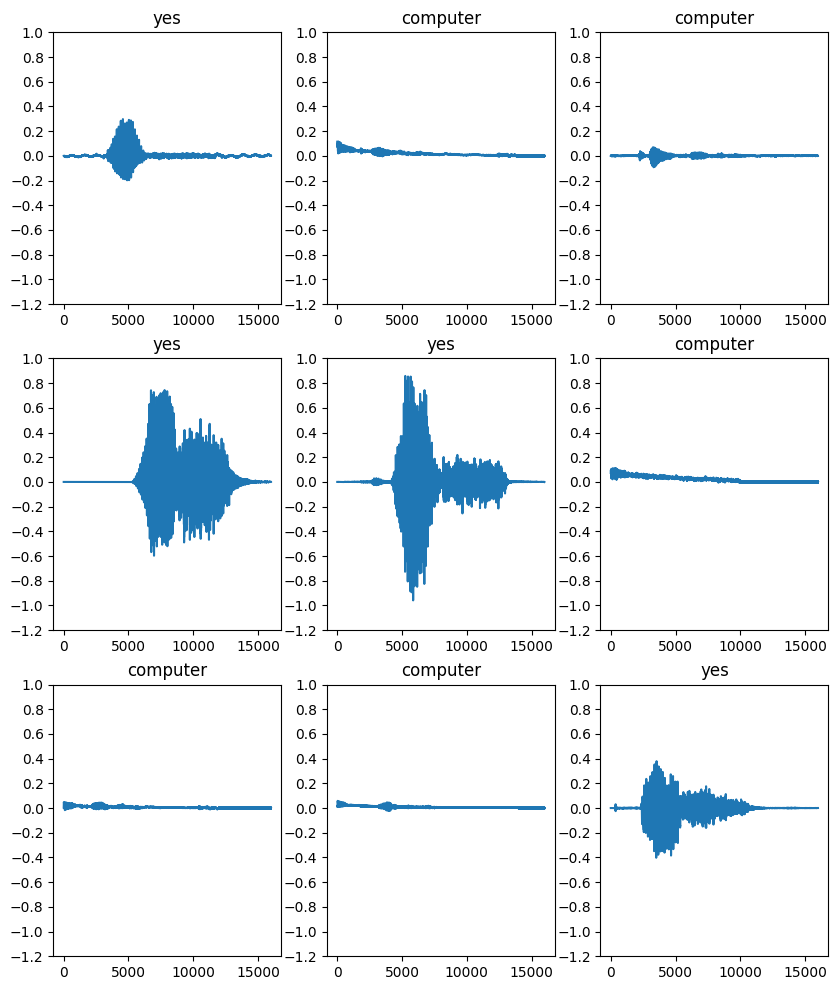

In [21]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [22]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (49, 40)
Audio playback


2023-05-01 12:14:11.795553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1412]
	 [[{{node Placeholder/_0}}]]


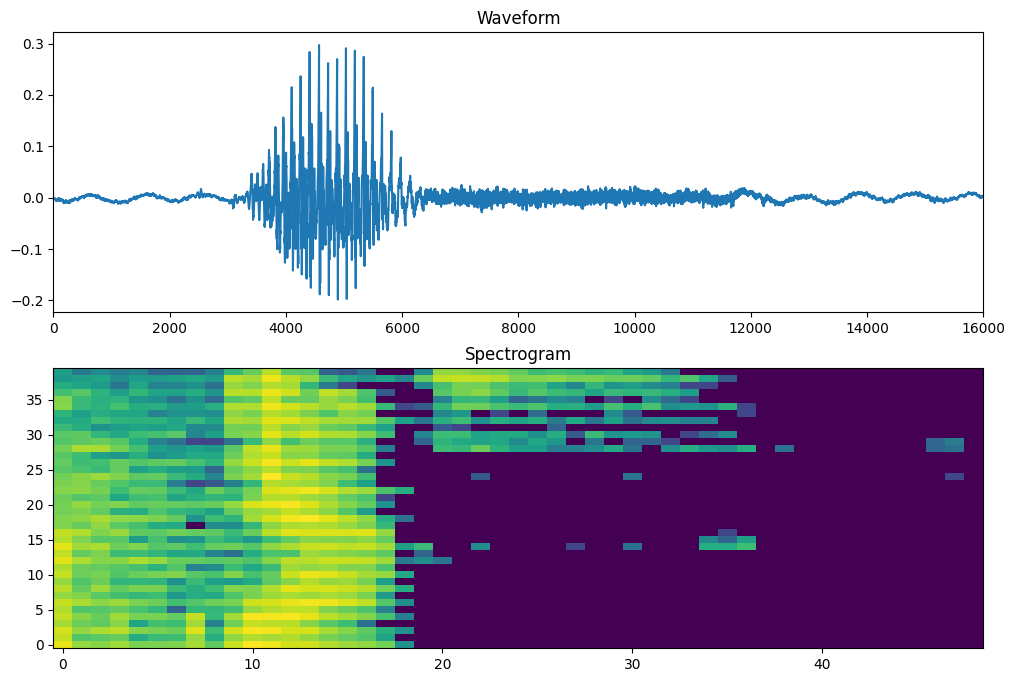

In [23]:
def plot_spectrogram(spectrogram, ax):
  # transpose so that the time is
  # represented in the x-axis (columns).
  freq_bins = spectrogram.shape[1]
  time_dur = spectrogram.shape[0]
  X = np.arange(time_dur)
  Y = range(freq_bins)
  ax.pcolormesh(X, Y, spectrogram.T)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [24]:
spectrogram.numpy().shape

(49, 40)

2023-05-01 12:14:12.129526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1412]
	 [[{{node Placeholder/_1}}]]
/tmp/ipykernel_48840/1859809011.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.set_title(label_list[np.int(label_id)])


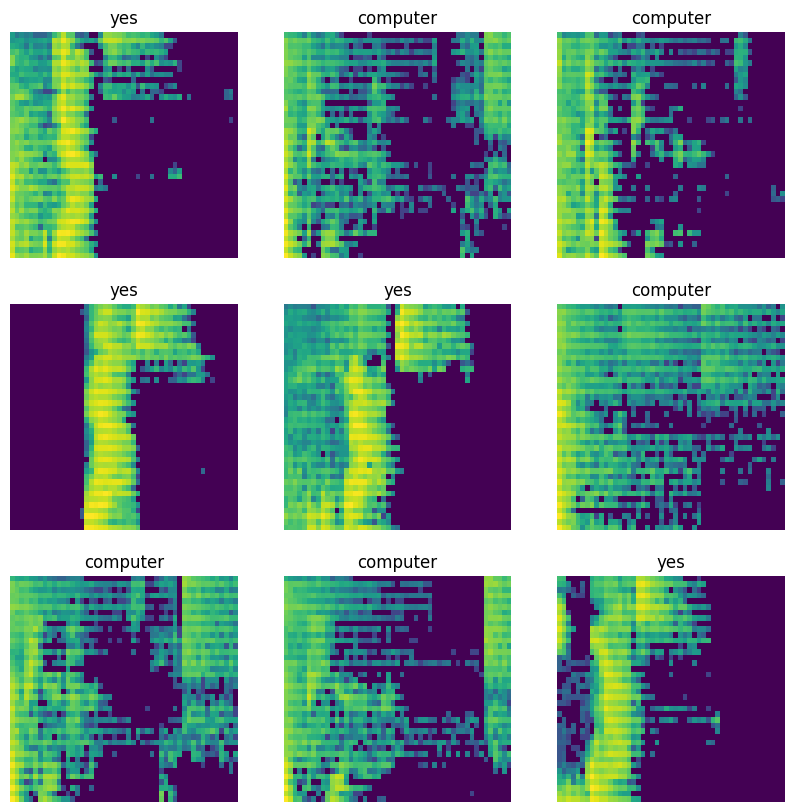

In [25]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(label_list[np.int(label_id)])
  ax.axis('off')

plt.show()

In [26]:
def copy_with_noise(ds_input, rms_level=0.25):
  rng = tf.random.Generator.from_seed(1234)
  wave_shape = tf.constant((wave_length_samps,))
  def add_noise(waveform, label):
    noise = rms_level*rng.normal(shape=wave_shape)
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)    
    noisy_wave = waveform + noise
    return noisy_wave, label

  return ds_input.map(add_noise)

In [27]:
# waveform_ds = augment_with_noise(waveform_ds)
count = 0
for w,l in waveform_ds:
  if w.shape != (16000,):
    print(f"element {count} has shape {w.shape}")
    break
  count += 1
print(count)

element 17 has shape (10403,)
17


In [28]:
def pad_16000(waveform, label):
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)        
    return waveform, label

In [29]:
def count_labels(dataset):
    counts = {}
    for _, lbl in dataset:
        if lbl.dtype == tf.string:
            label = lbl.numpy().decode('utf-8')
        else:
            label = lbl.numpy()
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

In [30]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None):
  # if noisy_reps_of_known is not None, it should be a list of rms noise levels
  # For every target word in the data set, 1 copy will be created with each level 
  # of noise added to it.  So [0.1, 0.2] will add 2x noisy copies of the target words 
  if num_silent is None:
    num_silent = int(0.2*len(files))+1
  print(f"Processing {len(files)} files")
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  if noisy_reps_of_known is not None:
    # create a few copies of only the target words to balance the distribution
    # create a tmp dataset with only the target words
    ds_only_cmds = waveform_ds.filter(lambda w,l: tf.reduce_any(l == commands))
    for noise_level in noisy_reps_of_known:
       waveform_ds = waveform_ds.concatenate(copy_with_noise(ds_only_cmds, rms_level=noise_level))
  if num_silent > 0:
    silent_wave_ds = create_silence_dataset(num_silent, wave_length_samps, 
                                            rms_noise_range=[0.01,0.2], 
                                            silent_label=silence_str)
    waveform_ds = waveform_ds.concatenate(silent_wave_ds)
  print(f"Added {num_silent} silent wavs and ?? noisy wavs")
  num_waves = 0
  output_ds = wavds2specds(waveform_ds)
  return output_ds

In [31]:
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")

We have 1412/203/402 training/validation/test files


In [32]:
# print(train_files[:20])
print(label_list)
train_files[:20]

tmp_ds = preprocess_dataset(train_files[:20])
print(count_labels(tmp_ds))

with tf.device('/CPU:0'): # needed on M1 mac
    tmp_ds = preprocess_dataset(train_files[:20], noisy_reps_of_known=[0.05,0.1])
    print(count_labels(tmp_ds))

['_silence', '_unknown', 'computer', 'yes']
Processing 20 files
Added 5 silent wavs and ?? noisy wavs
About to create spectrograms from 25 waves
 0 wavs processed{3: 8, 2: 12, 0: 5}
Processing 20 files


2023-05-01 12:14:12.481460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [5]
	 [[{{node Placeholder/_4}}]]
2023-05-01 12:14:12.574142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [25]
	 [[{{node Placeholder/_1}}]]


Added 5 silent wavs and ?? noisy wavs
About to create spectrograms from 65 waves


2023-05-01 12:14:12.704453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype string and shape [20]
	 [[{{node Placeholder/_11}}]]


 0 wavs processed{3: 24, 2: 36, 0: 5}


2023-05-01 12:14:13.116853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [65]
	 [[{{node Placeholder/_1}}]]


In [33]:
# Check if a GPU is available
if tf.test.is_gpu_available():
    # Use the GPU for data preprocessing
    with tf.device('/GPU:0'):
        train_ds = preprocess_dataset(train_files, noisy_reps_of_known=[0.05,0.1,0.15,0.2,0.25])
        val_ds = preprocess_dataset(val_files)
        test_ds = preprocess_dataset(test_files)
else:
    # Use the CPU for data preprocessing
    with tf.device('/CPU:0'):
        train_ds = preprocess_dataset(train_files, noisy_reps_of_known=[0.05,0.1,0.15,0.2,0.25])
        val_ds = preprocess_dataset(val_files)
        test_ds = preprocess_dataset(test_files)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-05-01 12:14:13.136534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 12:14:13.136683: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Processing 1412 files
Added 283 silent wavs and ?? noisy wavs


2023-05-01 12:14:13.446368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_31' with dtype int32 and shape [1]
	 [[{{node Placeholder/_31}}]]


About to create spectrograms from 8740 waves
 8500 wavs processedProcessing 203 files
Added 41 silent wavs and ?? noisy wavs
About to create spectrograms from 244 waves
 0 wavs processed

2023-05-01 12:14:26.929935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [41]
	 [[{{node Placeholder/_4}}]]


Processing 402 files
Added 81 silent wavs and ?? noisy wavs
About to create spectrograms from 483 waves
 0 wavs processed

2023-05-01 12:14:27.318330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [81]
	 [[{{node Placeholder/_4}}]]


 250 wavs processed

In [34]:
print("training data set")
print(count_labels(train_ds))
print("val_ds data set")
print(count_labels(val_ds))
print("test_ds data set")
print(count_labels(test_ds))

training data set


2023-05-01 12:14:28.024121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [8740]
	 [[{{node Placeholder/_1}}]]


{3: 4200, 2: 4254, 1: 3, 0: 283}
val_ds data set
{2: 103, 3: 100, 0: 41}
test_ds data set
{2: 202, 3: 200, 0: 81}


2023-05-01 12:14:28.734811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [244]
	 [[{{node Placeholder/_1}}]]
2023-05-01 12:14:28.761817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [483]
	 [[{{node Placeholder/_1}}]]


In [35]:
train_ds = train_ds.shuffle(int(len(train_files)*1.2))
val_ds = val_ds.shuffle(int(len(val_files)*1.2))
test_ds = test_ds.shuffle(int(len(test_files)*1.2))

In [36]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [37]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [38]:
for spectrogram, _ in train_ds.take(1):
  spec1 = spectrogram
# take(1) takes 1 *batch*, so we have to select the first 
# spectrogram from it, hence the [0]
print(f"Spectrogram shape {spec1[0].shape}")
print(f"ranges from {np.min(spec1)} to {np.max(spec1)}")   # min/max across the whole batch

Spectrogram shape (49, 40, 1)
ranges from 0.0 to 658.0


2023-05-01 12:14:28.874454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [8740]
	 [[{{node Placeholder/_1}}]]
2023-05-01 12:14:28.882147: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [39]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
  input_shape = spectrogram[0].shape  
print('Input shape:', input_shape)
num_labels = len(label_list)

Input shape: (49, 40, 1)


2023-05-01 12:14:28.908448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8740,49,40,1]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:14:28.915200: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [40]:
# from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# # Define a function to create your model with hyperparameters as inputs
# def create_model(l2_value=0.01, lr=0.001, epochs=25):
#     model = models.Sequential([
#         layers.Input(shape=input_shape),
#         layers.Conv2D(20, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(l2_value),name='conv1'),
#         layers.MaxPooling2D(name='pool1'),
#         layers.BatchNormalization(name='batch1'),
#         layers.DepthwiseConv2D(kernel_size=(3,3), padding='same',kernel_regularizer=regularizers.l2(l2_value),name='depthconv1'),
#         layers.Conv2D(32, 1, activation='relu',kernel_regularizer=regularizers.l2(l2_value),name='conv2'),
#         layers.MaxPooling2D(pool_size=(4,4),name='pool2'),
#         layers.BatchNormalization(name='batch2'),
#         layers.Dropout(0.2,name='dropout1'),
#         layers.Flatten(name='flatten'),
#         layers.Dense(64, activation='relu',name='dense1'),
#         layers.Dropout(0.2,name='dropout2'),
#         layers.Dense(64, activation='relu',name='dense2'),
#         layers.Dropout(0.2,name='dropout3'),
#         layers.Dense(num_labels),
#     ], name="simple_cnn")
    
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=['accuracy'],
#     )
    
#     history = model.fit(
#         train_X, train_y, 
#         validation_data=val_ds,  
#         epochs=epochs,
#         verbose=0,
#     )
#     return model

# # Create a KerasClassifier from your model
# keras_model = KerasClassifier(build_fn=create_model)

# # Define the hyperparameters to search
# param_grid = {
#     'l2_value': [0.01, 0.001, 0.0001],
#     'lr': [0.001, 0.0001, 0.00001],
#     'epochs': [10, 25, 50],
# }

# # Create a GridSearchCV object
# grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3)

# # Extract input and target arrays from the train_ds dataset
# train_X = np.concatenate([x for x, _ in train_ds.as_numpy_iterator()])
# train_y = np.concatenate([y for _, y in train_ds.as_numpy_iterator()])

# # Fit the GridSearchCV object to your data
# grid_search.fit(train_X, train_y, verbose=0)

# # Print the best parameters and the corresponding accuracy score
# print('Best parameters:', grid_search.best_params_)
# print('Best score:', grid_search.best_score_)

In [41]:
print('Input shape:', input_shape)
from tensorflow.keras import regularizers
l2_value = 0.01

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, DepthwiseConv2D, Dropout, MaxPooling2D, Flatten, Dense

model = tf.keras.Sequential([
    Input(shape=input_shape, name='input'),
    Conv2D(32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='conv1'),
    BatchNormalization(name='batch1'),
    Dropout(0.3),  # add dropout layer

    DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv2'),
    Conv2D(64, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv2'),
    BatchNormalization(name='batch2'),
    Dropout(0.3),  # add dropout layer

#     DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv3'),
#     Conv2D(128, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv3'),
#     BatchNormalization(name='batch3'),
#     Dropout(0.3),  # add dropout layer

#     DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv4'),
#     Conv2D(128, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv4'),
#     BatchNormalization(name='batch4'),
#     Dropout(0.3),  # add dropout layer

#     DepthwiseConv2D(kernel_size=(3,3), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv5'),
#     Conv2D(128, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv5'),
#     BatchNormalization(name='batch5'),
#     Dropout(0.3),  # add dropout layer

#     DepthwiseConv2D(kernel_size=(3,3), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv6'),
#     Conv2D(128, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv6'),
#     BatchNormalization(name='batch6'),
#     Dropout(0.3),  # add dropout layer

#     DepthwiseConv2D(kernel_size=(3,3), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='depth_conv7'),
#     Conv2D(128, kernel_size=(1,1), activation="relu", padding='same', kernel_regularizer=regularizers.l2(l2_value), name='point_conv7'),
#     BatchNormalization(name='batch7'),

    #finishing layers
    MaxPooling2D(pool_size=(3, 3), strides=(4, 4), name='pool'),
    Flatten(name='flatten'),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_value), name='dense1'),
    layers.Dense(num_labels),

], name="simple_cnn")

model.summary()

Input shape: (49, 40, 1)
Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 25, 20, 32)        320       
                                                                 
 batch1 (BatchNormalization)  (None, 25, 20, 32)       128       
                                                                 
 dropout (Dropout)           (None, 25, 20, 32)        0         
                                                                 
 depth_conv2 (DepthwiseConv2  (None, 13, 10, 32)       320       
 D)                                                              
                                                                 
 point_conv2 (Conv2D)        (None, 13, 10, 64)        2112      
                                                                 
 batch2 (BatchNormalization)  (None, 13, 10, 64)       256       
                               

In [42]:
l2_value=0.01
lr=0.001
EPOCHS=25

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/25


2023-05-01 12:14:29.114885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8740,49,40,1]
	 [[{{node Placeholder/_0}}]]


137/137 [==============================] - 4s 23ms/step - loss: 1.7980 - accuracy: 0.6178 - val_loss: 1.8342 - val_accuracy: 0.4918
Epoch 2/25
  1/137 [..............................] - ETA: 2s - loss: 1.4859 - accuracy: 0.8281

2023-05-01 12:14:33.228522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [244,49,40,1]
	 [[{{node Placeholder/_0}}]]


137/137 [==============================] - 2s 17ms/step - loss: 1.3181 - accuracy: 0.7130 - val_loss: 1.3943 - val_accuracy: 0.6516
Epoch 3/25
137/137 [==============================] - 2s 18ms/step - loss: 1.0773 - accuracy: 0.7537 - val_loss: 1.0460 - val_accuracy: 0.7172
Epoch 4/25
137/137 [==============================] - 2s 18ms/step - loss: 0.9212 - accuracy: 0.7725 - val_loss: 0.8098 - val_accuracy: 0.7910
Epoch 5/25
137/137 [==============================] - 2s 17ms/step - loss: 0.7977 - accuracy: 0.7865 - val_loss: 0.6617 - val_accuracy: 0.7951
Epoch 6/25
137/137 [==============================] - 3s 20ms/step - loss: 0.7178 - accuracy: 0.7939 - val_loss: 0.6612 - val_accuracy: 0.7910
Epoch 7/25
137/137 [==============================] - 3s 22ms/step - loss: 0.6588 - accuracy: 0.8059 - val_loss: 0.6294 - val_accuracy: 0.7787
Epoch 8/25
137/137 [==============================] - 3s 19ms/step - loss: 0.6138 - accuracy: 0.8118 - val_loss: 0.5093 - val_accuracy: 0.8074
Epoch 9/25

In [43]:
import os
from datetime import datetime as dt

# Define the path to the model directory
model_dir = "/home/david/Documents/GitHub/project-2-team-1/model/"

# Create the model directory if it does not exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Navigate to the model directory
os.chdir(model_dir)

model_file_name = f"model.h5" 

# Save the model to the model file
print(f"Saving model to {model_file_name}")
model.save(model_file_name, overwrite=True)

Saving model to model.h5


In [44]:
with open(model_file_name.split('.')[0] + '.txt', 'w') as fpo:
    fpo.write(f"i16min            = {i16min           }\n")
    fpo.write(f"i16max            = {i16max           }\n")
    fpo.write(f"fsamp             = {fsamp            }\n")
    fpo.write(f"wave_length_ms    = {wave_length_ms   }\n")
    fpo.write(f"wave_length_samps = {wave_length_samps}\n")
    fpo.write(f"window_size_ms    = {window_size_ms   }\n")
    fpo.write(f"window_step_ms    = {window_step_ms   }\n")
    fpo.write(f"num_filters       = {num_filters      }\n")
    fpo.write(f"use_microfrontend = {use_microfrontend}\n")
    fpo.write(f"label_list        = {label_list}\n")
    fpo.write(f"spectrogram_shape = {spectrogram.numpy().shape}\n")


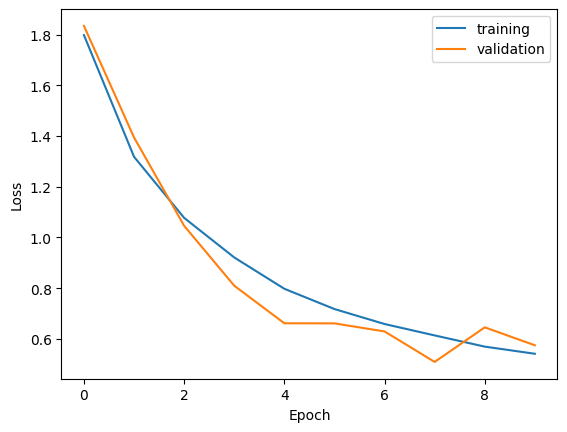

In [45]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

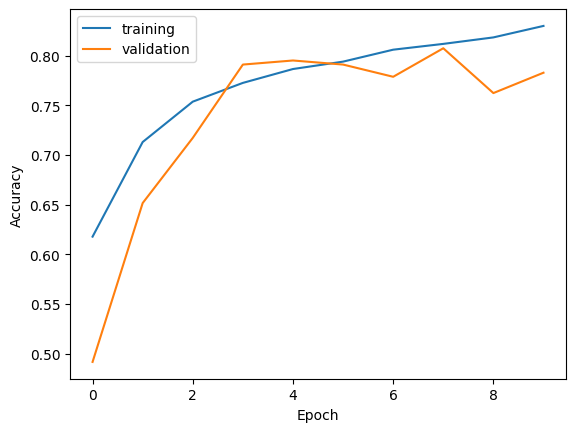

In [46]:
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [47]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

2023-05-01 12:14:56.774528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [483]
	 [[{{node Placeholder/_1}}]]


In [48]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

16/16 [==============================] - 0s 5ms/step
Test set accuracy: 80%


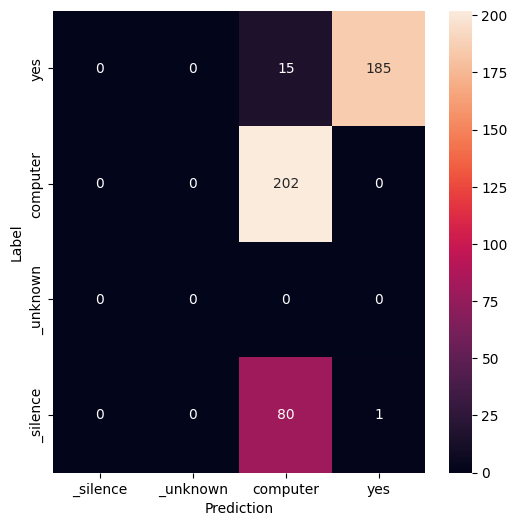

In [49]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('/home/david/Documents/GitHub/project-2-team-1/figs/train_confusion_matrix.png')  # Save the confusion matrix as an image
plt.show()

On training set:


2023-05-01 12:14:57.434010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8740,49,40,1]
	 [[{{node Placeholder/_0}}]]


274/274 [==============================] - 1s 4ms/step
Data set accuracy: 77%


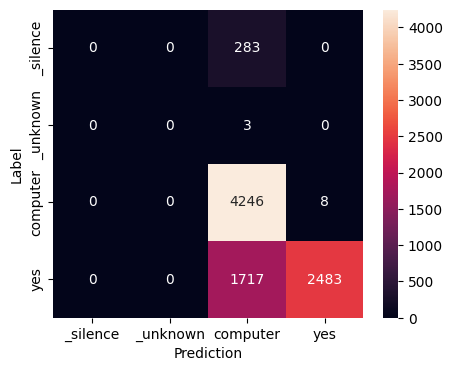

In [50]:
dset = train_ds.unbatch()
print("On training set:")

ds_audio = []
ds_labels = []

for audio, label in dset:
  ds_audio.append(audio.numpy())
  ds_labels.append(label.numpy())

ds_labels = np.array(ds_labels)
ds_audio = np.array(ds_audio)

model_out = model.predict(ds_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = ds_labels

ds_acc = sum(y_pred == y_true) / len(y_true)
print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('/home/david/Documents/GitHub/project-2-team-1/figs/test_confusion_matrix.png')  # Save the confusion matrix as an image
plt.show()

Processing 2 files
Added 1 silent wavs and ?? noisy wavs
About to create spectrograms from 3 waves
 0 wavs processed

2023-05-01 12:14:59.723737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-01 12:14:59.820728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3]
	 [[{{node Placeholder/_1}}]]


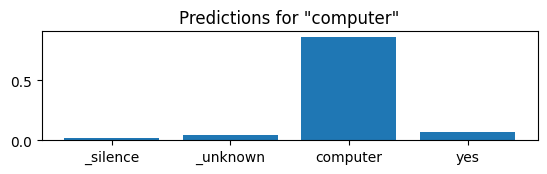

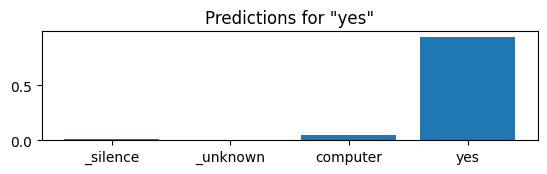

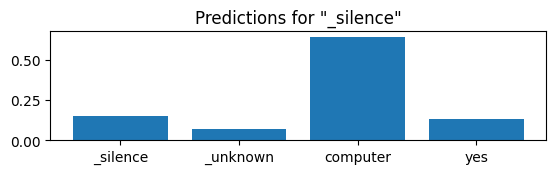

In [51]:
sample_files = [data_dir/'computer/computer_163128.wav',                 
                data_dir/'yes/0ab3b47d_nohash_0.wav',                  
               ]
fstr_list = [str(f) for f in sample_files]
sample_ds = preprocess_dataset(fstr_list, num_silent=1)

count = 1
for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.subplot(len(sample_files)+1, 1, count)
  plt.bar(label_list, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{label_list[label[0]]}"')
  
  filename = f'predictions_{label_list[label[0]]}.png'  # Generate a unique filename for each figure
  filepath = os.path.join('/home/david/Documents/GitHub/project-2-team-1/figs', filename)  # Set the directory path for the image
  plt.savefig(filepath)  # Save the figure as an image
  plt.show()

  count += 1


## Quantize and Convert to TFLite

In [52]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [53]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

2023-05-01 12:15:00.229846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [244]
	 [[{{node Placeholder/_1}}]]
2023-05-01 12:15:00.230235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [244]
	 [[{{node Placeholder/_1}}]]


In [54]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

In [55]:
tflite_quant_model = converter.convert()

2023-05-01 12:15:00.593380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,25,20,32]
	 [[{{node inputs}}]]
2023-05-01 12:15:00.610349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,13,10,64]
	 [[{{node inputs}}]]
2023-05-01 12:15:00.886857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,25,20,32]
	 [[{{node inputs}}]]
2

INFO:tensorflow:Assets written to: /tmp/tmptr8qi9m4/assets


INFO:tensorflow:Assets written to: /tmp/tmptr8qi9m4/assets
/home/david/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-05-01 12:15:02.100483: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-01 12:15:02.100504: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-01 12:15:02.100849: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptr8qi9m4
2023-05-01 12:15:02.103063: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-01 12:15:02.103076: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptr8qi9m4
2023-05-01 12:15:02.110488: I tensorflow/compiler/mlir/mlir_graph_

In [56]:
fname = 'model.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

Wrote 24528 / 24528 bytes to tflite file


In [57]:
!xxd -i model.tflite >! model.cc

In [58]:
import tensorflow as tf

# Load the model
interpreter = tf.lite.Interpreter(model_path="/home/david/Documents/GitHub/project-2-team-1/model/model.tflite")
interpreter.allocate_tensors()

# Get the input tensor and check the shape
input_details = interpreter.get_input_details()
print("Input shape:", input_details[0]['shape'])

# Get the output tensor and check the shape
output_details = interpreter.get_output_details()
print("Output shape:", output_details[0]['shape'])

Input shape: [ 1 49 40  1]
Output shape: [1 4]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [59]:
import tensorflow as tf
import numpy as np

# Load the model
interpreter = tf.lite.Interpreter(model_path="/home/david/Documents/GitHub/project-2-team-1/model/model.tflite")
interpreter.allocate_tensors()

# Get the input tensor and check the shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print("Input shape:", input_shape)

# Assume a default batch size of 1
height, width, channels = input_shape[1:]

# Create a random input tensor
x = tf.constant(np.random.rand(1, height, width, channels), dtype=tf.float32)

# Create the feature extraction model and extract features
feature_model = tf.keras.Model(inputs=model.input, outputs=model.layers[4].output)
features = feature_model(x)

print("Features shape:", features.shape)

Input shape: [ 1 49 40  1]
Features shape: (1, 13, 10, 64)
